In [ ]:
!pip install TensorFlow==2.15.0
!pip install tensorflow-decision-forests==1.8.1
!pip install tensorflowjs

  Using cached tensorflow_decision_forests-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.3 MB)
  Attempting uninstall: tensorflow-decision-forests
    Found existing installation: tensorflow_decision_forests 1.9.1
    Uninstalling tensorflow_decision_forests-1.9.1:
      Successfully uninstalled tensorflow_decision_forests-1.9.1


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.16.0
    Uninstalling tf_keras-2.16.0:
      Successfully uninstalled tf_keras-2.16.0


In [ ]:
import tensorflowjs as tfjs
print(tfjs.__version__)

4.20.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Langkah 2: Download File ZIP
!pip install gdown
!gdown --id 1uOs1dFP1iFjzbX4cD4i5zsEu0xPcHAlo -O /content/dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1uOs1dFP1iFjzbX4cD4i5zsEu0xPcHAlo
From (redirected): https://drive.google.com/uc?id=1uOs1dFP1iFjzbX4cD4i5zsEu0xPcHAlo&confirm=t&uuid=b3bcfec7-1c4b-4f76-bac3-3609ca62bb40
To: /content/dataset.zip
100% 373M/373M [00:01<00:00, 193MB/s]


In [ ]:
# Langkah 3: Ekstrak File ZIP
import zipfile
import os

zip_file_path = '/content/dataset.zip'
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List isi folder hasil ekstraksi
extracted_files = os.listdir(extract_path)
print(extracted_files)

['dataset-sampah']


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset-sampah",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7000 files belonging to 7 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Organic', 'botol plastik', 'kaca', 'kardus', 'kertas', 'metal', 'plastic']

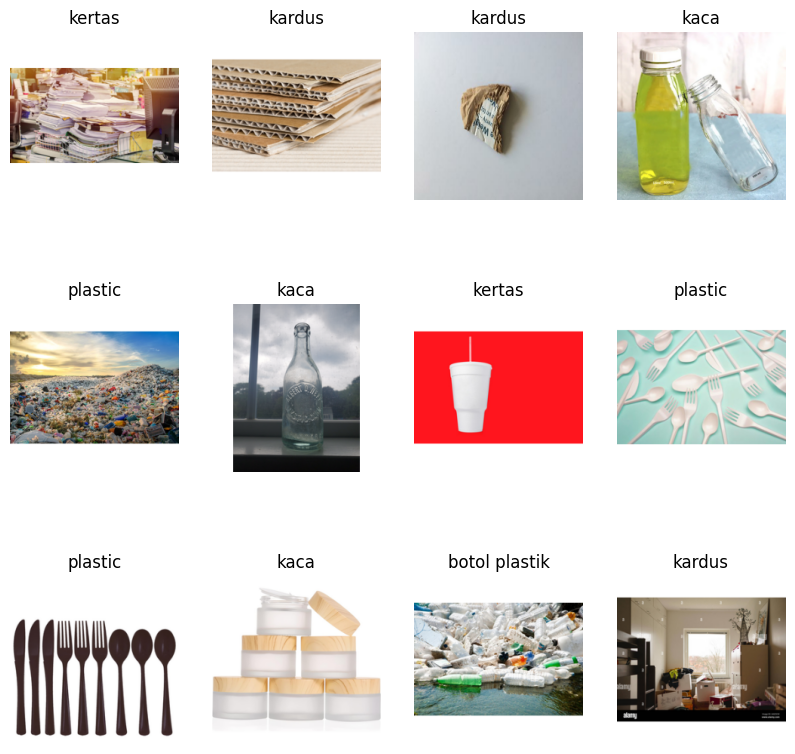

In [ ]:
# Displaying sample images after preprocessing
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Langkah 2: Split Dataset Menjadi Training dan Test Set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Langkah 3: Normalisasi Dataset
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(normalize_img)
test_dataset = test_dataset.map(normalize_img)

# Langkah 4: Prefetch untuk Performa yang Lebih Baik
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_rotation(image, angles=30)
    image = tf.image.random_zoom(image, zoom_range=(0.3, 0.3))
    image = tf.image.random_shift(image, width_shift_range=0.3, height_shift_range=0.3)
    image = tf.image.random_shear(image, shear_range=0.3)
    return image, label

In [ ]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Menggunakan MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
# Membekukan semua lapisan kecuali lapisan terakhir
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Membangun model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Kompilasi model dengan learning rate scheduler
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callback untuk mengatur learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
175/175 [==============================] - 51s 172ms/step - loss: 0.7060 - accuracy: 0.7725 - val_loss: 5.4514 - val_accuracy: 0.5607 - lr: 0.0010
Epoch 2/50
175/175 [==============================] - 10s 58ms/step - loss: 0.3566 - accuracy: 0.8875 - val_loss: 4.7638 - val_accuracy: 0.5921 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - 11s 61ms/step - loss: 0.2029 - accuracy: 0.9343 - val_loss: 4.5787 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - 10s 55ms/step - loss: 0.1944 - accuracy: 0.9413 - val_loss: 6.2309 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - 11s 61ms/step - loss: 0.1394 - accuracy: 0.9571 - val_loss: 4.7626 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 6/50
175/175 [==============================] - 10s 56ms/step - loss: 0.1247 - accuracy: 0.9643 - val_loss: 8.2744 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 7/50
175/175 [==============================] - 10s

In [ ]:
# Clear the session
tf.keras.backend.clear_session()

In [ ]:
scores = model.evaluate(test_dataset)

44/44 [==============================] - 2s 39ms/step - loss: 0.8465 - accuracy: 0.9021


In [ ]:
scores

[0.846514105796814, 0.9021428823471069]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 175}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.706025242805481,
 0.35663551092147827,
 0.20292480289936066,
 0.1944345086812973,
 0.13936284184455872]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

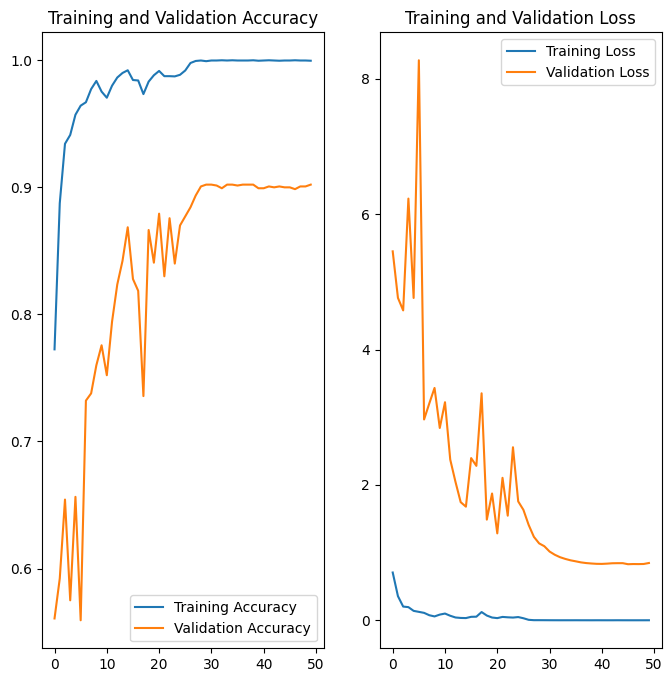

In [ ]:
# Assuming you have the history object from the model.fit call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs actually completed
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: plastic
1/1 [==============================] - 1s 850ms/step
predicted label: plastic


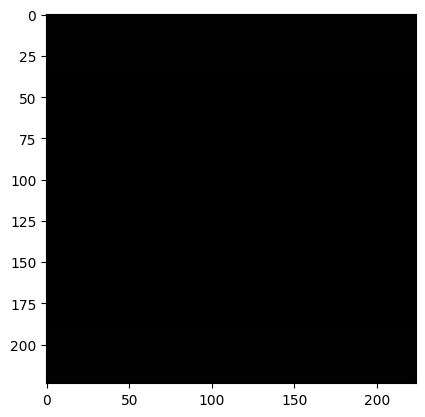

In [ ]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 23ms/step


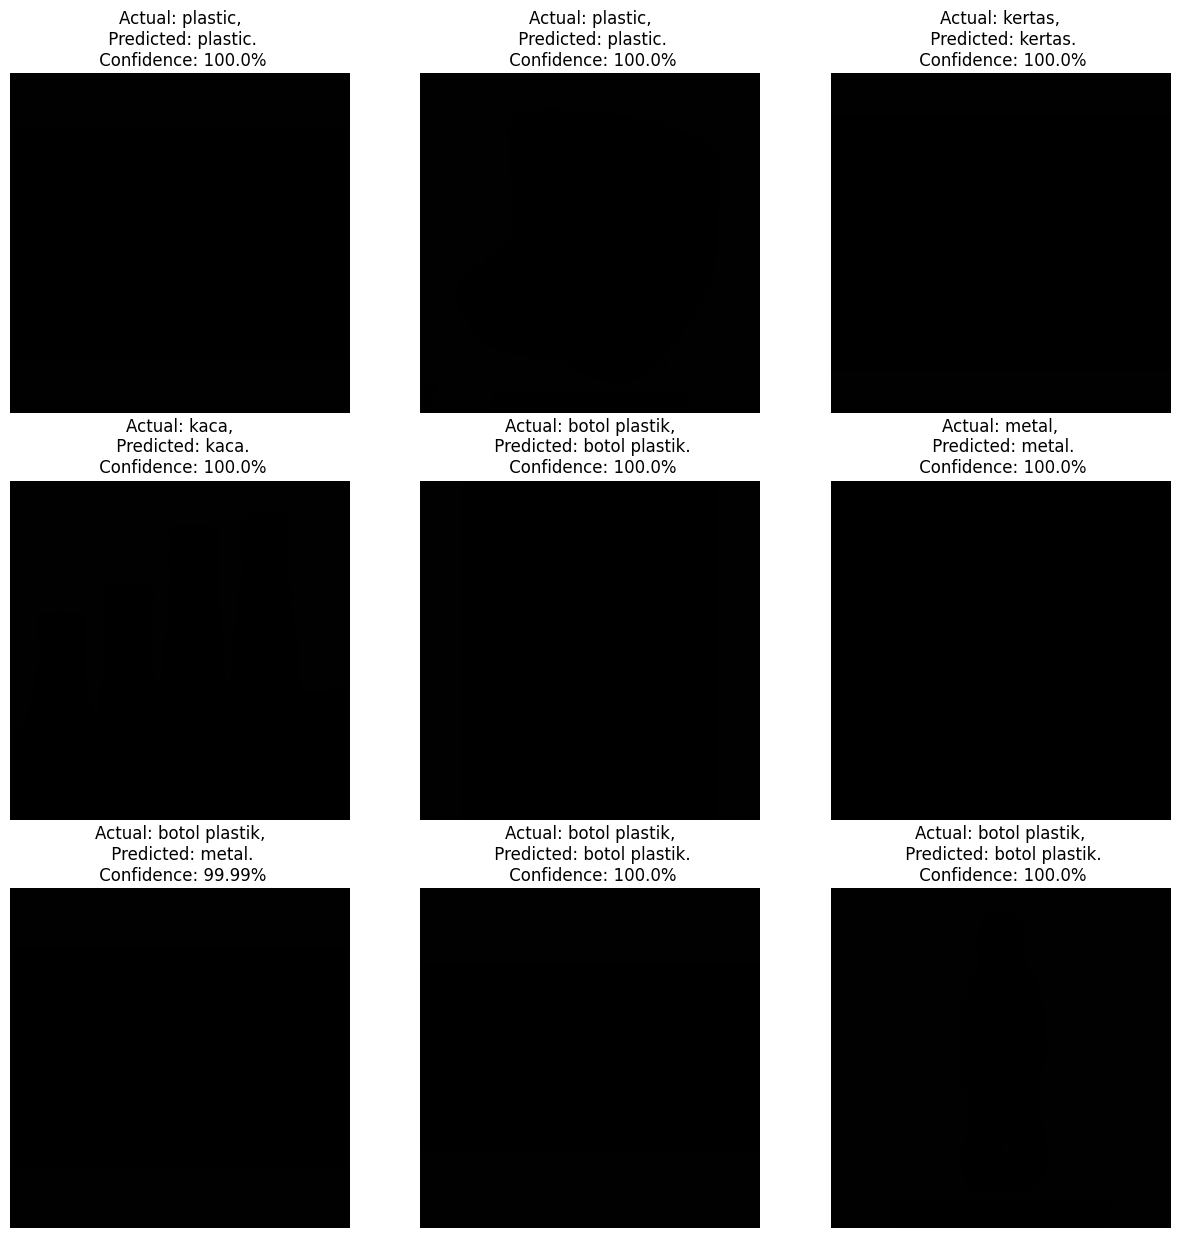

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

44/44 [==============================] - 2s 38ms/step


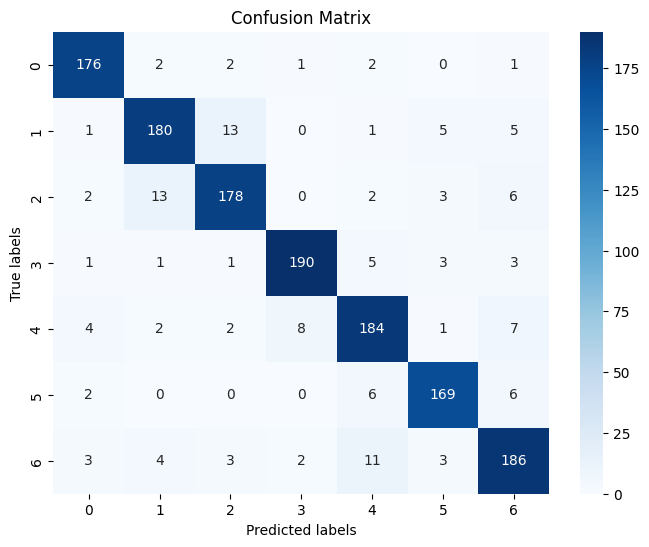

In [ ]:
#heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prediksi target dengan model
predictions = model.predict(test_dataset)

# Konversi prediksi menjadi label kelas
predicted_labels = np.argmax(predictions, axis=1)

# Ambil label sebenarnya dari data uji
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Hitung matriks kebingungan
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualisasikan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Buat laporan klasifikasi
class_report = classification_report(true_labels, predicted_labels)

print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       184
           1       0.89      0.88      0.88       205
           2       0.89      0.87      0.88       204
           3       0.95      0.93      0.94       204
           4       0.87      0.88      0.88       208
           5       0.92      0.92      0.92       183
           6       0.87      0.88      0.87       212

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400



In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'models')

import shutil
# Lokasi folder yang ingin Anda kompres
folder_path = '/content/models'

# Lokasi tempat menyimpan file ZIP
zip_path = '/content/models.zip'

# Kompres folder menjadi file ZIP
shutil.make_archive('/content/models', 'zip', folder_path)

# Lokasi file ZIP yang ingin diunggah
zip_file = '/content/models.zip'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
